# Network in Network

LeNet, AlexNet and VGG all broadly operate under a single design pattern. They extract features from spatial information via convolutional layers, then output this information via flattening to fully connected layers. The improvements across them largely depend on how the networks become deeper and wider. 

The major drawback of this architecture is the gigantic amount of RAM required for the final, fully connected layers. Almost 400MB, which was effectively the total amount of ram of any phone of the time, and still a significant portion today. 

Equally, adding fully connected layers earlier in the structure would destroy the spatial information entirely, so isn't possible. 

The Network in Network (NiN) architecture, offered an alternative to this by using 1x1 convolutions across channel to add non-linearities across channel layers. And then used _global average_ pooling to integrate over all locations in the final representational layer. 

The idea of network in network architecture is effectively to have an entire fully-connected layer connecting each pixel location. 

In [15]:
import torch
from torch import nn
from d2l import torch as d2l
import datetime

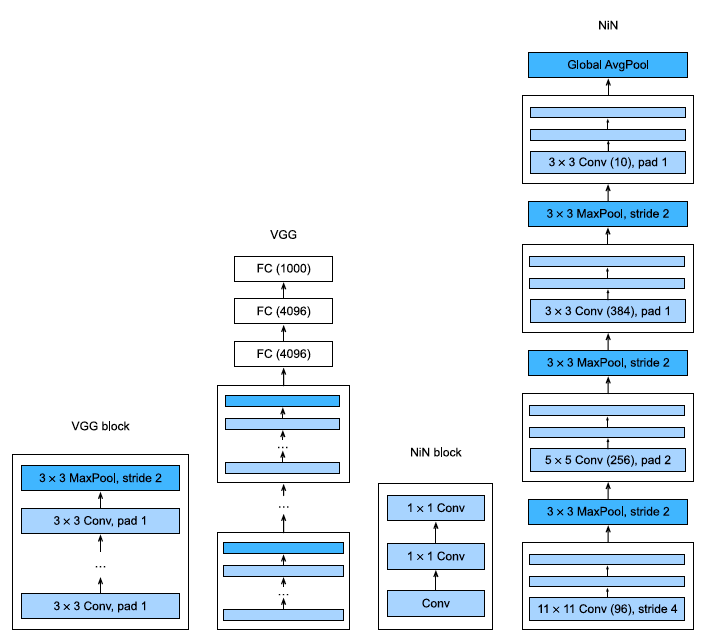

^ Comparison between VGG and NiN block architectures. Where VGG consists of multiple 3x3 convolutions followed by max pooling, NiN consists of one convolution followed by two 1x1 convolutions to introduce nonlinearities between the channel layers.

In [3]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        # Large convolution
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),

        # additional 1x1 convolutions
        nn.LazyConv2d(out_channels, kernel_size = 1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size = 1), nn.ReLU()
    )

## NiN Model

NiN uses the same initial convolution sizes as AlexNet, with kernel sizes of 11x11, 5x5 and 3x3. Each of these convolutions is followed by two 1x1 convolutions. These in turn are followed by a 3x3 max pooling layer with stride 2. 

NiN avoids fully connected output layers entirely, instead using a NiN block with a number of output channels equal to the number of label classes. There is then a _global_ average pooling layer, which yields a vector of logits. So the averaging is done over the entire output on a per-channel basis.

In [11]:
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(out_channels=96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(out_channels=256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(out_channels=384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(out_channels=num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten()
        )

        self.net.apply(d2l.init_cnn)

In [12]:
NiN().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## Training

In [16]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)

if torch.cuda.is_available():
    trainer.fit(model, data)
    
    # Save the parameters since this is expensive
    name = model.__class__.__name__ + "-" + data.__class__.__name__ + "-" + datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + ".pt"
    torch.save(model.state_dict(), name)
else: 
    print("You're not training this without a GPU. If you really wanna, you can remove this check")

You're not training this without a GPU. If you really wanna, you can remove this check


In [18]:
name = model.__class__.__name__ + "-" + data.__class__.__name__ + "-" + datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + ".pt"
name

'NiN-FashionMNIST-2025-03-26-11-25-37.pt'

## Summary

NiN has substantially fewer parameters than AlexNet and VHH, primarily stemming from the fact that it doesn't have fully connected layers to produce the final output categorisation. Surprisingly, replacing these learned layers with a simple average over convolutional channels does not impact accuracy, and even improves on the amount of translational invariance a model can handle. 

Choosing fewer convolutions with wide kernels and replacing these with a larger number of 1x1 convolutions further reduces the number of parameters required. These two innovations, 1x1 convolutions and global average pooling, significantly affected later CNN designs. 